# Imports

In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Set Paths

In [2]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

# Load Data

In [3]:
# Load the ABF file
abf = pyabf.ABF(f'{project_path}DS5R2 CNQX ACCOM.abf')



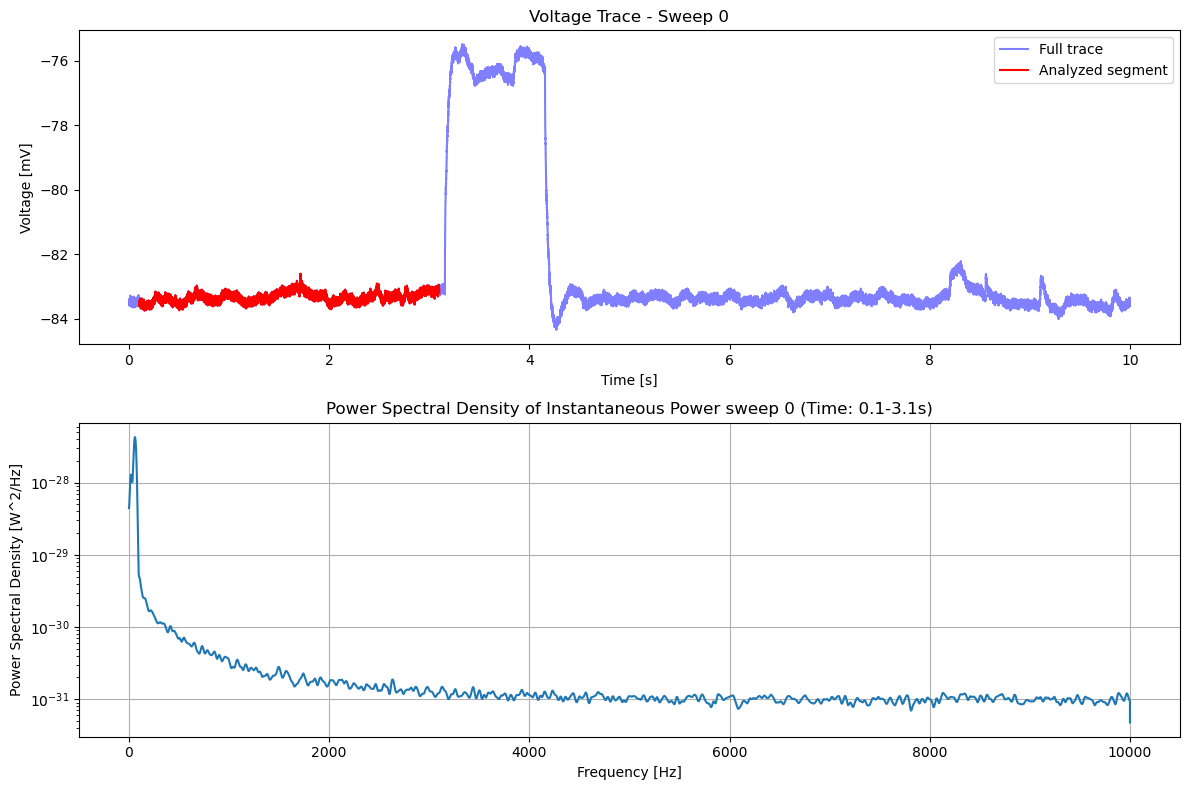

Analysis for sweep 0 time segment: 0.1 to 3.1 seconds
Total power for sweep 0 (excluding <0.1 Hz): 5.605153e-02 yoctoWatt


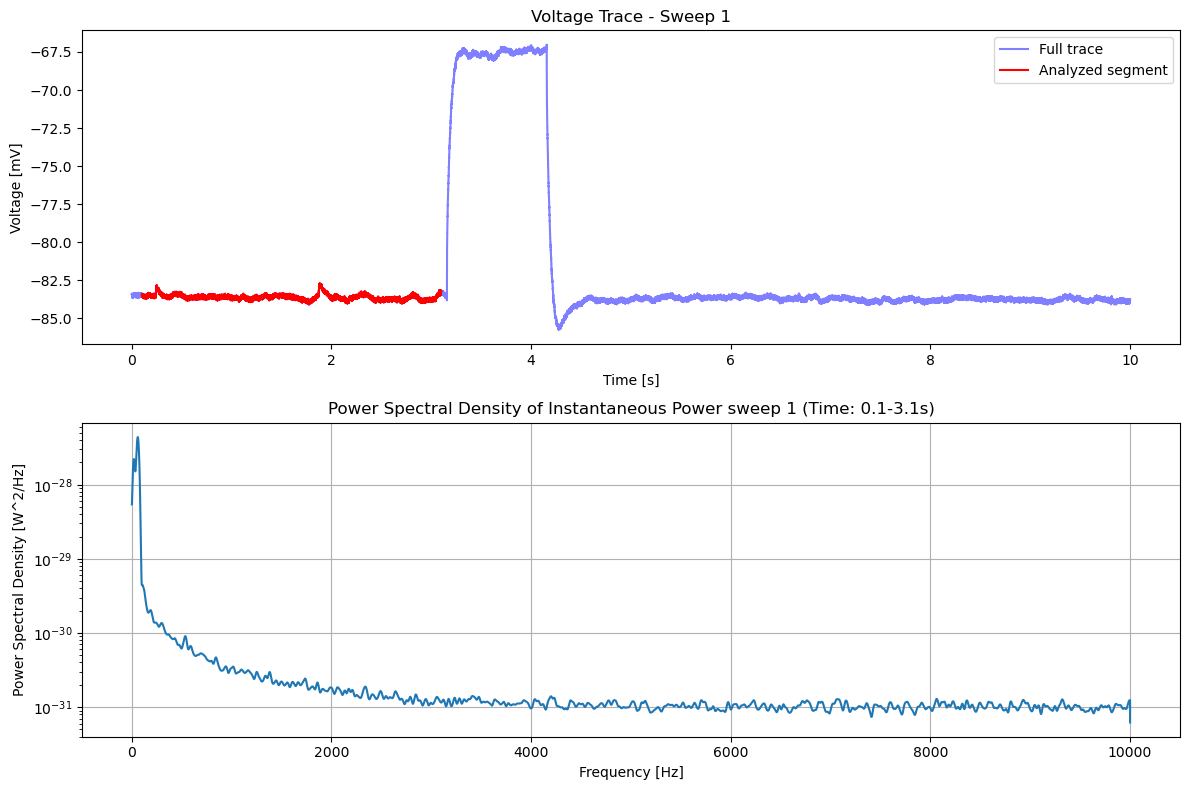

Analysis for sweep 1 time segment: 0.1 to 3.1 seconds
Total power for sweep 1 (excluding <0.1 Hz): 6.447242e-02 yoctoWatt


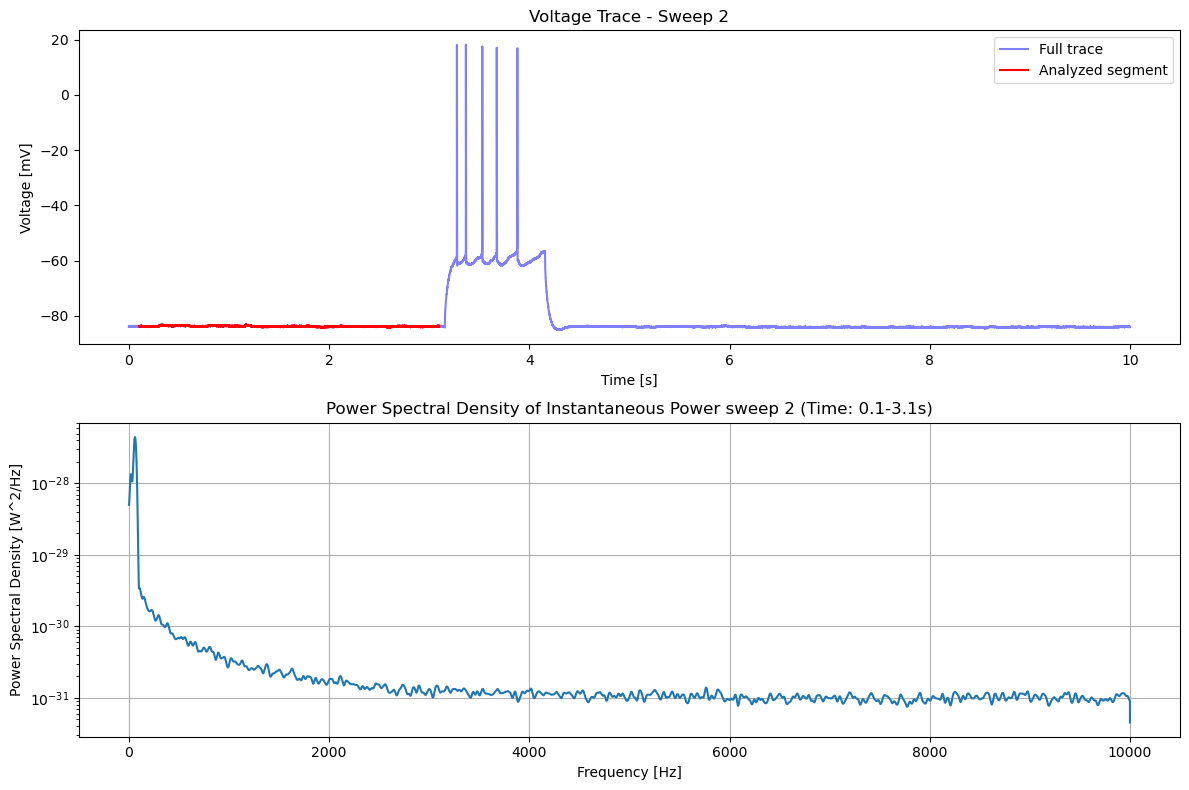

Analysis for sweep 2 time segment: 0.1 to 3.1 seconds
Total power for sweep 2 (excluding <0.1 Hz): 5.839994e-02 yoctoWatt


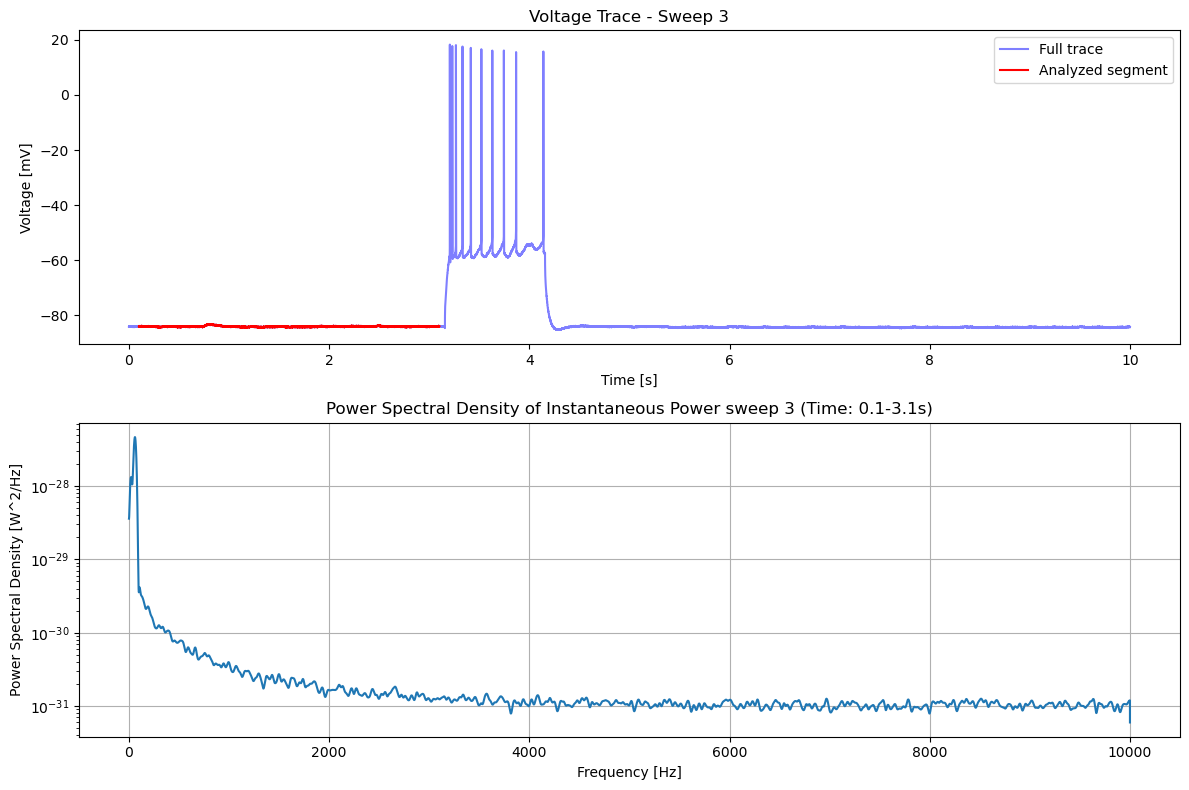

Analysis for sweep 3 time segment: 0.1 to 3.1 seconds
Total power for sweep 3 (excluding <0.1 Hz): 5.930450e-02 yoctoWatt


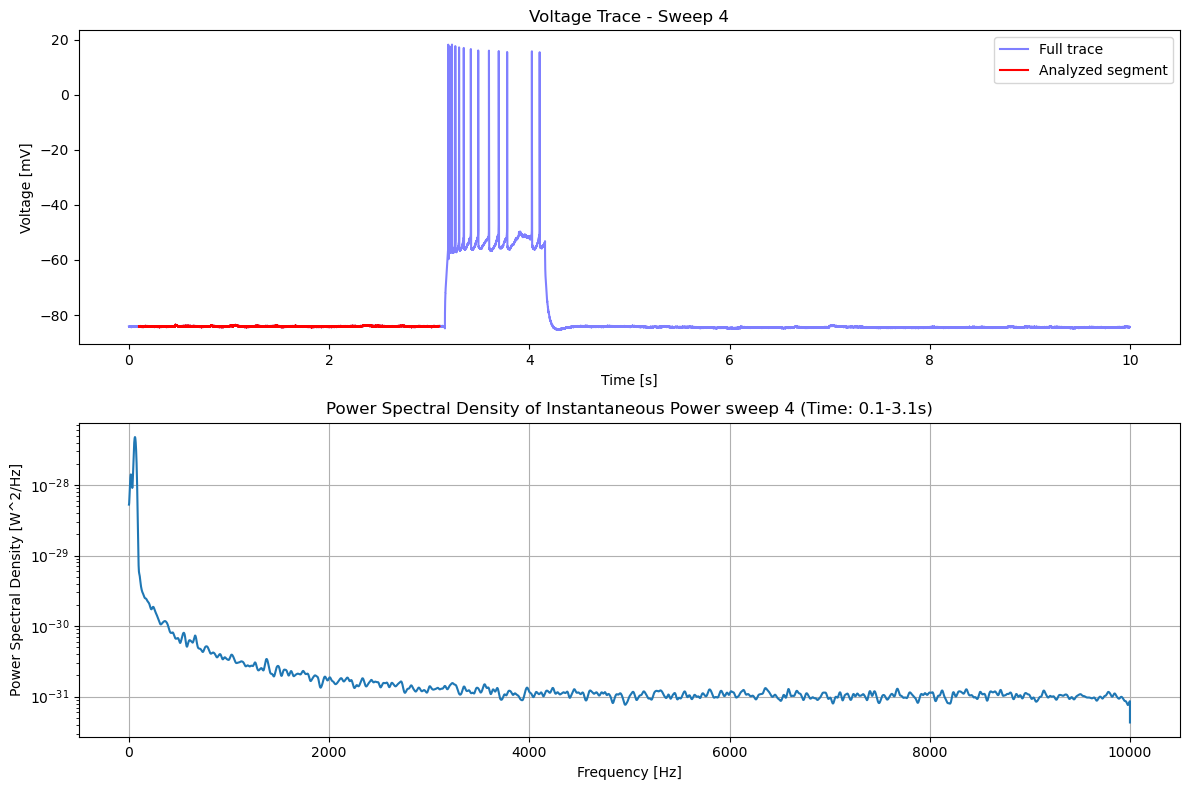

Analysis for sweep 4 time segment: 0.1 to 3.1 seconds
Total power for sweep 4 (excluding <0.1 Hz): 6.069782e-02 yoctoWatt


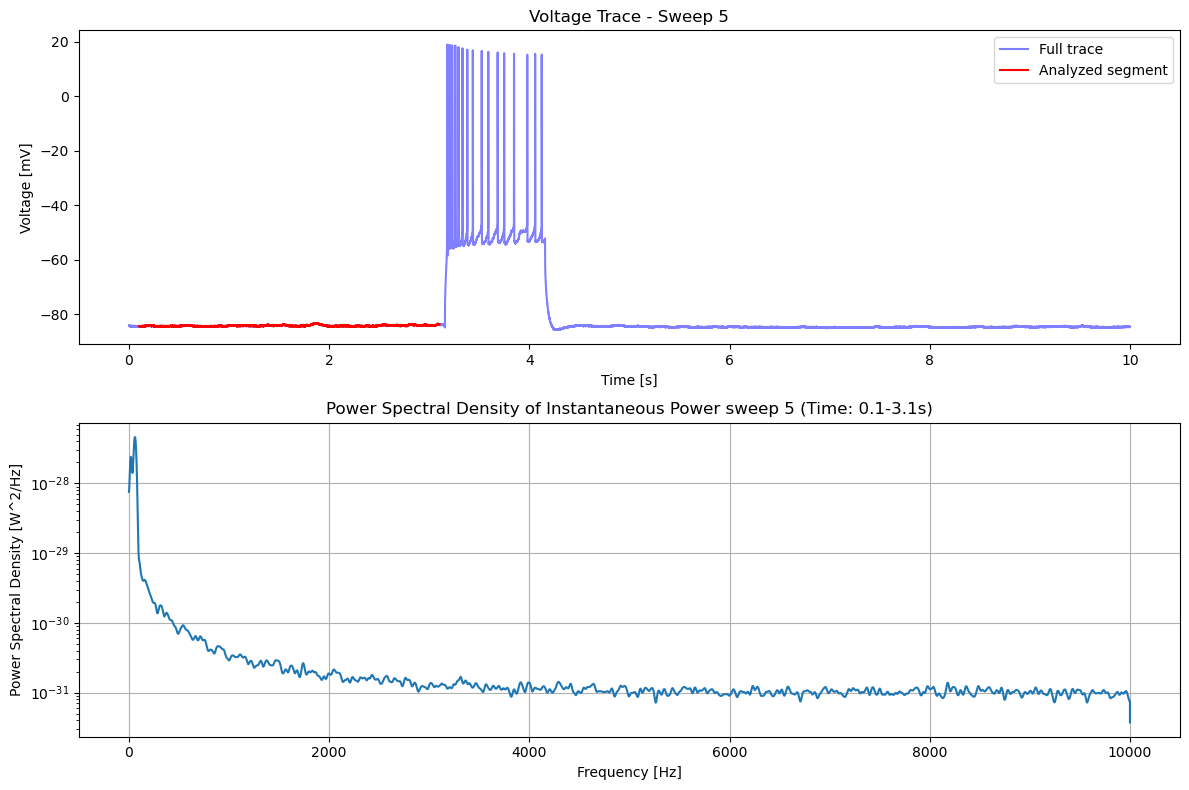

Analysis for sweep 5 time segment: 0.1 to 3.1 seconds
Total power for sweep 5 (excluding <0.1 Hz): 6.888663e-02 yoctoWatt


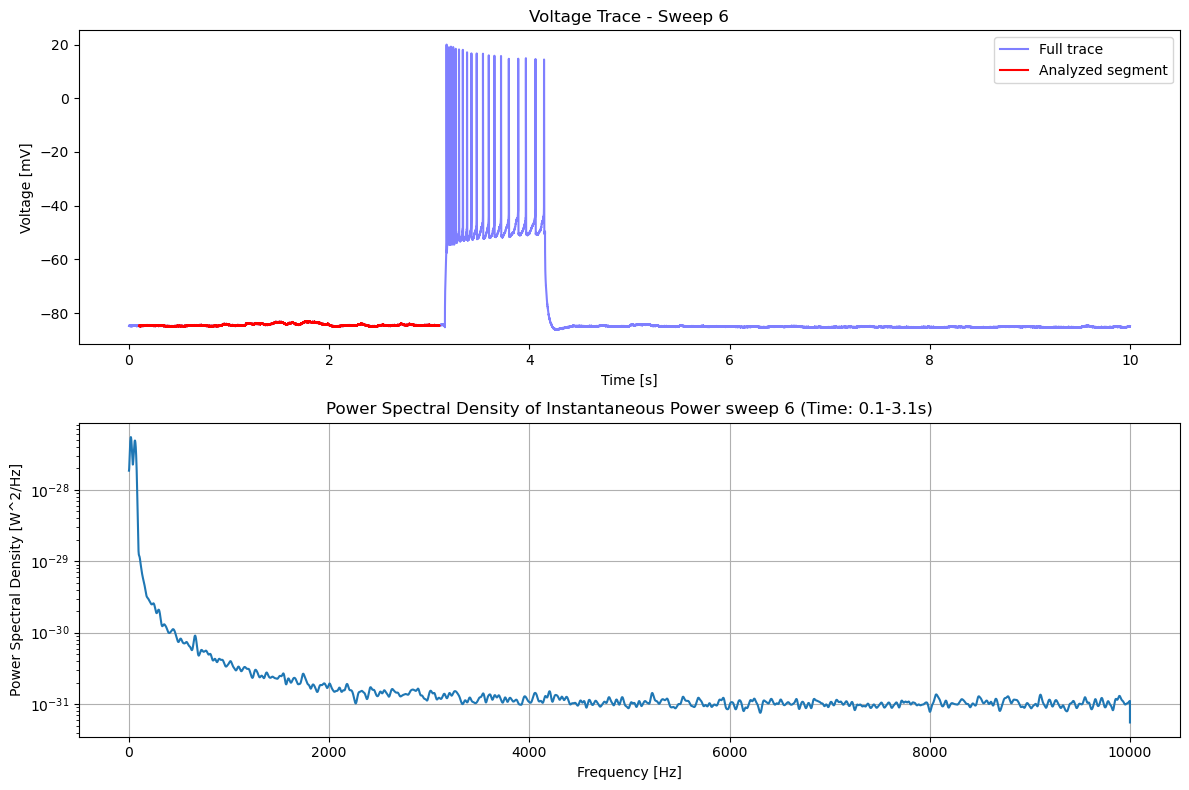

Analysis for sweep 6 time segment: 0.1 to 3.1 seconds
Total power for sweep 6 (excluding <0.1 Hz): 9.680779e-02 yoctoWatt


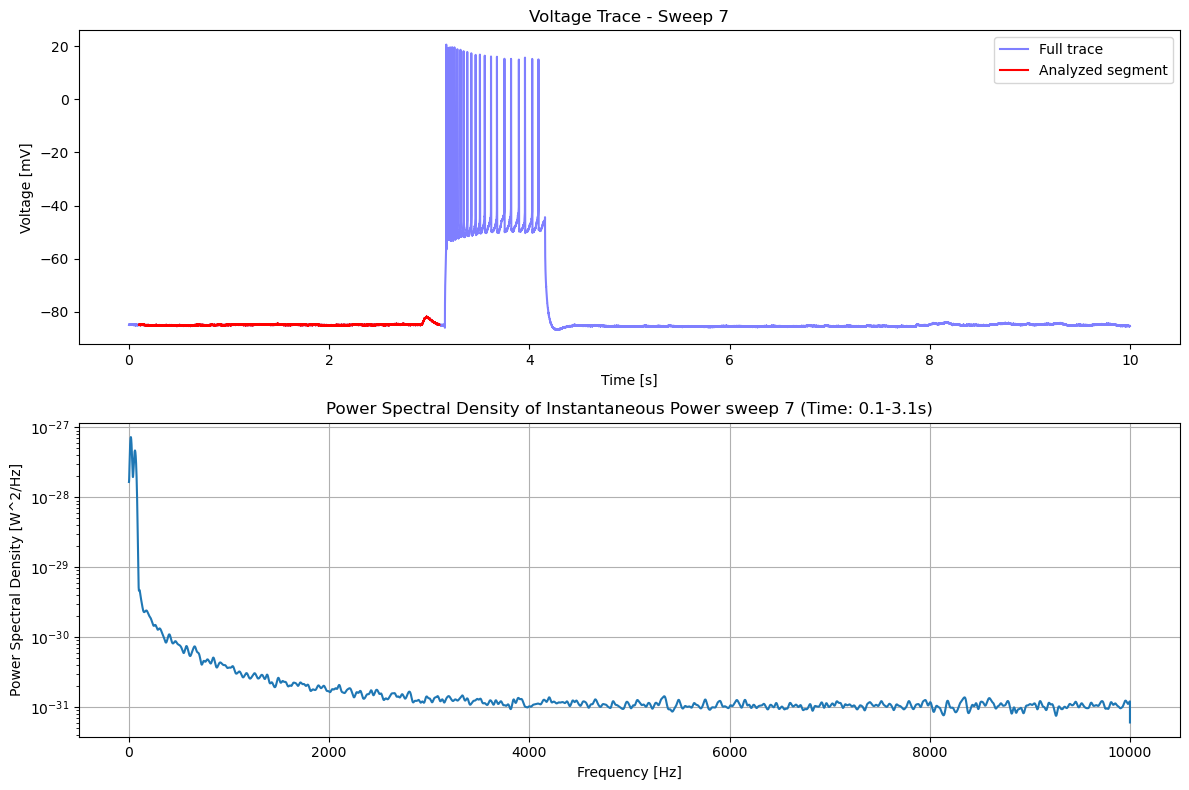

Analysis for sweep 7 time segment: 0.1 to 3.1 seconds
Total power for sweep 7 (excluding <0.1 Hz): 1.014376e-01 yoctoWatt

Total power for each sweep:
Sweep 0: 5.605153e-02 yoctoWatt
Sweep 1: 6.447242e-02 yoctoWatt
Sweep 2: 5.839994e-02 yoctoWatt
Sweep 3: 5.930450e-02 yoctoWatt
Sweep 4: 6.069782e-02 yoctoWatt
Sweep 5: 6.888663e-02 yoctoWatt
Sweep 6: 9.680779e-02 yoctoWatt
Sweep 7: 1.014376e-01 yoctoWatt

Average total power across all sweeps: 7.075728e-02 yoctoWatt

Sum of total power across all sweeps: 5.660583e-01 yoctoWatt


In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Set the desired sweep and channel
sweep_numbers = [0,1,2,3,4,5,6,7]
total_power_per_sweep = {}  # Dictionary to store total power for each sweep

# Input resistance (MegaOhms) - you can change this value as needed
input_resistance_MOhm = float(input("Enter the input resistance in MegaOhms: "))
input_resistance = input_resistance_MOhm * 1e6  # Convert MegaOhms to Ohms

LJP = 13  # Liquid Junction Potential in mV

for sweep in sweep_numbers:
    abf.setSweep(sweep, channel=0)
    # Define the time segment for analysis (in seconds)
    start_time = 0.1  # Start time in seconds
    end_time = 3.1    # End time in seconds

    # Extract voltage (sweepY) and time (sweepX)
    voltage = abf.sweepY - LJP  # Voltage in mV
    times = abf.sweepX    # Time in seconds

    # Find indices corresponding to the desired time segment
    start_index = np.argmin(np.abs(times - start_time))
    end_index = np.argmin(np.abs(times - end_time))

    # Extract the specific portion of the data for analysis
    segment_times = times[start_index:end_index]
    segment_voltage = voltage[start_index:end_index]

    # Convert voltage from mV to V for power calculation
    segment_voltage_V = segment_voltage * 1e-3

    # Calculate instantaneous power using input resistance: P = V^2 / R
    instantaneous_power = (segment_voltage_V ** 2) / input_resistance
    
    # Calculate the Power Spectral Density (PSD) of the instantaneous power using Welch's method with zero padding
    fs = abf.dataRate  # Sampling frequency from ABF file
    segment_length_ms = 50  # Optimal segment length in milliseconds
    nperseg = int(fs * segment_length_ms / 1000)
    noverlap = nperseg // 2  # 50% overlap

    # Ensure nperseg is an even number for efficient FFT
    nperseg = nperseg + (nperseg % 2)

    # Zero padding
    nfft = 320000  # Increase FFT size such that frequency resolution is 0.05Hz

    # Apply Welch's method with zero padding
    f, Pxx = signal.welch(instantaneous_power, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='density')

    # Calculate total power excluding frequencies below 0.1 Hz
    freq_mask = (f >= 0.1) & (f <= 10000)
    average_power_above_0_1Hz = np.trapz(Pxx[freq_mask], f[freq_mask])  # Integrate PSD above 0.1 Hz

    # Calculate the duration of the sweep
    sweep_duration = end_time - start_time

    # Calculate total power by multiplying average power by the duration
    total_power_above_0_1Hz = average_power_above_0_1Hz * sweep_duration * 1e24  # Convert to yoctoWatt

    # Store the total power for this sweep
    total_power_per_sweep[sweep] = total_power_above_0_1Hz

    # Plot the PSD and exclude all frequencies below 0.1 Hz
    plt.figure(figsize=(12, 8))

    # Plot 1: Original voltage trace with highlighted segment
    plt.subplot(2, 1, 1)
    plt.plot(times, voltage, 'b', alpha=0.5, label='Full trace')
    plt.plot(segment_times, segment_voltage, 'r', label='Analyzed segment')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [mV]')
    plt.title(f'Voltage Trace - Sweep {sweep}')
    plt.legend()

    # Plot 2: PSD of instantaneous power
    plt.subplot(2, 1, 2)
    plt.semilogy(f[freq_mask], Pxx[freq_mask])  # Focus on frequencies above 0.1 Hz
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power Spectral Density [W^2/Hz]')
    plt.title(f'Power Spectral Density of Instantaneous Power sweep {sweep} (Time: {start_time}-{end_time}s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Analysis for sweep {sweep} time segment: {start_time} to {end_time} seconds")
    print(f"Total power for sweep {sweep} (excluding <0.1 Hz): {total_power_above_0_1Hz:.6e} yoctoWatt")

# Print the total power for each sweep
print("\nTotal power for each sweep:")
for sweep, power in total_power_per_sweep.items():
    print(f"Sweep {sweep}: {power:.6e} yoctoWatt")

# Calculate and print the average total power across all sweeps
average_total_power = np.mean(list(total_power_per_sweep.values()))
print(f"\nAverage total power across all sweeps: {average_total_power:.6e} yoctoWatt")

# Print the sum of total power across all sweeps
total_power_sum = sum(total_power_per_sweep.values())
print(f"\nSum of total power across all sweeps: {total_power_sum:.6e} yoctoWatt")